# Calculating calibration densities and plotting models at UCB
- This workbook shows how we calculate densities for calibration data, plot models and calculate the cali lines

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.58'

## Import the data (after fitting and pressure matching)

In [4]:
caldata=pd.read_excel(r"G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Cali_line\UCB_4-10-23\merged_dataframe.xlsx").drop(columns={'Unnamed: 0'})
caldata.head()

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr
0,FDCA-P1-1,105.278861,105.542330,1280.792491,4867.117554,1280.792541,13387.837947,0.953561,5.548645,0.841382,...,2023-04-10 14:36:58,1681137418,102,2023-04-10 14:36:59.349,2023-04-10 14:38:41.349,62.489000,0.000706,31.603516,0.002679,FDCA-P1-1
1,FDCA-P1-2,105.280266,105.543643,1280.792425,5098.573503,1280.792475,13979.555935,0.950302,6.264735,0.841968,...,2023-04-10 14:41:43,1681137703,102,2023-04-10 14:41:44.324,2023-04-10 14:43:26.324,62.473144,0.001202,31.611328,0.002685,FDCA-P1-2
2,FDCA-P1-3,105.290329,105.553558,1280.781620,4778.454204,1280.781670,13157.924063,0.947101,5.704327,0.860791,...,2023-04-10 14:50:21,1681138221,102,2023-04-10 14:50:20.292,2023-04-10 14:52:02.292,62.452215,0.001161,31.642578,0.003603,FDCA-P1-3
3,FDCA-P2-1,105.255676,105.518715,1280.825834,4542.302741,1280.825884,12450.272583,0.946703,5.250776,0.850917,...,2023-04-10 14:55:33,1681138533,102,2023-04-10 14:55:32.269,2023-04-10 14:57:14.269,59.265227,0.001133,31.650391,0.004547,FDCA-P2-1
4,FDCA-P2-2,105.255296,105.518233,1280.825999,4654.776146,1280.826049,12838.667721,0.962176,5.180837,0.830392,...,2023-04-10 15:00:40,1681138840,102,2023-04-10 15:00:41.247,2023-04-10 15:02:23.247,59.250048,0.001667,31.667969,0.003524,FDCA-P2-2


In [5]:
manualdata=pd.read_excel(r"G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Cali_line\UCB_4-10-23\Experiment_37C_4-10-23.xlsx")
manualdata.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,T4_manual,Offset,T_AV,PAV
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,37.012,6 min,37.00775,62.4879
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,37.014,NaN,37.01375,62.4730
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,37.005,NaN,37.00175,62.4508
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,36.988,NaN,36.98825,59.2656
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,37.014,NaN,37.00400,59.2523


In [6]:
merged_df = pd.merge(right=caldata, left=manualdata, right_on='filename_nocrr',left_on='Label')
merged_df.to_clipboard(excel=True)

In [11]:
caldata

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr
0,FDCA-P1-1,105.278861,105.542330,1280.792491,4867.117554,1280.792541,13387.837947,0.953561,5.548645,8.413824e-01,...,2023-04-10 14:36:58,1681137418,102,2023-04-10 14:36:59.349,2023-04-10 14:38:41.349,62.489000,0.000706,31.603516,0.002679,FDCA-P1-1
1,FDCA-P1-2,105.280266,105.543643,1280.792425,5098.573503,1280.792475,13979.555935,0.950302,6.264735,8.419685e-01,...,2023-04-10 14:41:43,1681137703,102,2023-04-10 14:41:44.324,2023-04-10 14:43:26.324,62.473144,0.001202,31.611328,0.002685,FDCA-P1-2
2,FDCA-P1-3,105.290329,105.553558,1280.781620,4778.454204,1280.781670,13157.924063,0.947101,5.704327,8.607906e-01,...,2023-04-10 14:50:21,1681138221,102,2023-04-10 14:50:20.292,2023-04-10 14:52:02.292,62.452215,0.001161,31.642578,0.003603,FDCA-P1-3
3,FDCA-P2-1,105.255676,105.518715,1280.825834,4542.302741,1280.825884,12450.272583,0.946703,5.250776,8.509167e-01,...,2023-04-10 14:55:33,1681138533,102,2023-04-10 14:55:32.269,2023-04-10 14:57:14.269,59.265227,0.001133,31.650391,0.004547,FDCA-P2-1
4,FDCA-P2-2,105.255296,105.518233,1280.825999,4654.776146,1280.826049,12838.667721,0.962176,5.180837,8.303923e-01,...,2023-04-10 15:00:40,1681138840,102,2023-04-10 15:00:41.247,2023-04-10 15:02:23.247,59.250048,0.001667,31.667969,0.003524,FDCA-P2-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,FDCA-P75-2,102.779558,103.029810,1286.021480,446.649711,1286.021480,447.652255,0.446100,3.332986,1.611778e-01,...,2023-04-11 06:01:20,1681192880,227,2023-04-11 06:01:19.036,2023-04-11 06:05:06.036,0.964893,0.000882,31.083984,0.003112,FDCA-P75-2
152,FDCA-P75-3,102.774617,103.024876,1286.018890,435.542763,1286.018890,438.833348,0.457731,3.339593,9.968639e-02,...,2023-04-11 06:05:16,1681193116,226,2023-04-11 06:05:16.034,2023-04-11 06:09:02.034,0.967760,0.000692,31.096680,0.004626,FDCA-P75-3
153,FDCA-P76-1_CRR_DiadFit,102.786021,103.036418,1286.064022,132.752039,1286.064022,137.784604,0.447239,5.280771,2.585928e-01,...,2023-04-11 06:26:51,1681194411,182,2023-04-11 06:26:51.918,2023-04-11 06:29:53.918,0.396932,0.000619,31.076172,0.002926,FDCA-P76-1
154,FDCA-P76-2_CRR_DiadFit,102.771357,103.021745,1286.093902,136.024199,1286.093902,130.523948,0.378056,5.694110,4.989242e-01,...,2023-04-11 06:31:31,1681194691,181,2023-04-11 06:31:30.898,2023-04-11 06:34:31.898,0.395798,0.000411,31.066406,0.002640,FDCA-P76-2


In [12]:
manualdata

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,T4_manual,Offset,T_AV,PAV
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,37.012,6 min,37.007750,62.4879
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,37.014,NaN,37.013750,62.4730
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,37.005,NaN,37.001750,62.4508
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,36.988,NaN,36.988250,59.2656
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,37.014,NaN,37.004000,59.2523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,FDCA-P75-2,NaN,NaN,NaN,NaN,0.8637,37.006,37.004,37.017,37.015,37.016,NaN,37.010500,0.8637
157,FDCA-P75-3,NaN,NaN,NaN,NaN,0.8667,37.015,37.005,36.999,37.000,37.000,NaN,37.004750,0.8667
158,FDCA-P76-1,0.002893,310.15,0.005000,0.289300,0.2982,36.995,36.999,36.997,NaN,NaN,NaN,36.997000,0.2982
159,FDCA-P76-2,NaN,NaN,NaN,NaN,0.2952,36.984,36.999,36.997,NaN,NaN,NaN,36.993333,0.2952


In [10]:
print(len(caldata))
print(len(manualdata))

156
161


In [13]:
len(merged_df)

156

In [7]:
manualdata

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr
0,FDCA-P1-1,105.278861,105.542330,1280.792491,4867.117554,1280.792541,13387.837947,0.953561,5.548645,8.413824e-01,...,2023-04-10 14:36:58,1681137418,102,2023-04-10 14:36:59.349,2023-04-10 14:38:41.349,62.489000,0.000706,31.603516,0.002679,FDCA-P1-1
1,FDCA-P1-2,105.280266,105.543643,1280.792425,5098.573503,1280.792475,13979.555935,0.950302,6.264735,8.419685e-01,...,2023-04-10 14:41:43,1681137703,102,2023-04-10 14:41:44.324,2023-04-10 14:43:26.324,62.473144,0.001202,31.611328,0.002685,FDCA-P1-2
2,FDCA-P1-3,105.290329,105.553558,1280.781620,4778.454204,1280.781670,13157.924063,0.947101,5.704327,8.607906e-01,...,2023-04-10 14:50:21,1681138221,102,2023-04-10 14:50:20.292,2023-04-10 14:52:02.292,62.452215,0.001161,31.642578,0.003603,FDCA-P1-3
3,FDCA-P2-1,105.255676,105.518715,1280.825834,4542.302741,1280.825884,12450.272583,0.946703,5.250776,8.509167e-01,...,2023-04-10 14:55:33,1681138533,102,2023-04-10 14:55:32.269,2023-04-10 14:57:14.269,59.265227,0.001133,31.650391,0.004547,FDCA-P2-1
4,FDCA-P2-2,105.255296,105.518233,1280.825999,4654.776146,1280.826049,12838.667721,0.962176,5.180837,8.303923e-01,...,2023-04-10 15:00:40,1681138840,102,2023-04-10 15:00:41.247,2023-04-10 15:02:23.247,59.250048,0.001667,31.667969,0.003524,FDCA-P2-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,FDCA-P75-2,102.779558,103.029810,1286.021480,446.649711,1286.021480,447.652255,0.446100,3.332986,1.611778e-01,...,2023-04-11 06:01:20,1681192880,227,2023-04-11 06:01:19.036,2023-04-11 06:05:06.036,0.964893,0.000882,31.083984,0.003112,FDCA-P75-2
152,FDCA-P75-3,102.774617,103.024876,1286.018890,435.542763,1286.018890,438.833348,0.457731,3.339593,9.968639e-02,...,2023-04-11 06:05:16,1681193116,226,2023-04-11 06:05:16.034,2023-04-11 06:09:02.034,0.967760,0.000692,31.096680,0.004626,FDCA-P75-3
153,FDCA-P76-1_CRR_DiadFit,102.786021,103.036418,1286.064022,132.752039,1286.064022,137.784604,0.447239,5.280771,2.585928e-01,...,2023-04-11 06:26:51,1681194411,182,2023-04-11 06:26:51.918,2023-04-11 06:29:53.918,0.396932,0.000619,31.076172,0.002926,FDCA-P76-1
154,FDCA-P76-2_CRR_DiadFit,102.771357,103.021745,1286.093902,136.024199,1286.093902,130.523948,0.378056,5.694110,4.989242e-01,...,2023-04-11 06:31:31,1681194691,181,2023-04-11 06:31:30.898,2023-04-11 06:34:31.898,0.395798,0.000411,31.066406,0.002640,FDCA-P76-2


In [ ]:
#creates a column with a new column that splits the filename to sample name (FDCA-P1-1 becomes FDCA-P1)
merged_df['filename_split'] = merged_df['filename_x'].str.split('-', n=2).str[:2].str.join('-')
merged_df.head()

## Calculate mean T

In [ ]:
merged_df['T_C_mean'] = merged_df[['T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual']].replace(0, np.nan).mean(axis=1, skipna=True)
merged_df['T_C_std'] = merged_df[['T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual']].replace(0, np.nan).std(axis=1, skipna=True)

merged_df['rho_gmL']=pf.calculate_rho_for_P_T(P_kbar=np.array(merged_df['median_pressure']/100),
                                               T_K=np.array(merged_df['T_C_mean']+273.15), EOS='SW96')

merged_df.to_clipboard(excel=True)
merged_df.head()

## Plot of manually recorded pressure vs pressure transducer median and standard deviation over analysis duration

In [1]:
plt.errorbar(y=merged_df['median_pressure'],x=merged_df['P_manual'], yerr=merged_df['mad_pressure'], fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2)

plt.plot([-1, 65], [-1,65], color='black', linestyle='-',zorder=-1)

plt.xlabel('P_manual')
plt.ylabel('median_pressure')
plt.show()

NameError: name 'plt' is not defined

## Plot of density vs fermi splitting

In [45]:
cornellcell=pd.read_excel(r"C:\Users\charl\Desktop\1-s2.0-S0009254121004654-mmc1.xlsx")

In [81]:
rho_cornell=pf.calculate_density_cornell(temp='SupCrit', Split=merged_df['Corrected_Splitting'])
merged_df['cornellEQ_predrho']=rho_cornell['Preferred D']
merged_df.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,T_C_mean,T_C_std,rho_g/mL,rho_gmL,cornellEQ_predrho
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,...,62.489000,0.000706,31.603516,0.002679,FDCA-P1-1,37.0086,0.004450,1.034183,1.034183,1.025697
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,...,62.473144,0.001202,31.611328,0.002685,FDCA-P1-2,37.0138,0.001483,1.034131,1.034131,1.025976
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,...,62.452215,0.001161,31.642578,0.003603,FDCA-P1-3,37.0024,0.003435,1.034108,1.034108,1.027954
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,...,59.265227,0.001133,31.650391,0.004547,FDCA-P2-1,36.9882,0.000837,1.026057,1.026057,1.021013
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,...,59.250048,0.001667,31.667969,0.003524,FDCA-P2-2,37.0060,0.005000,1.025970,1.025970,1.020935


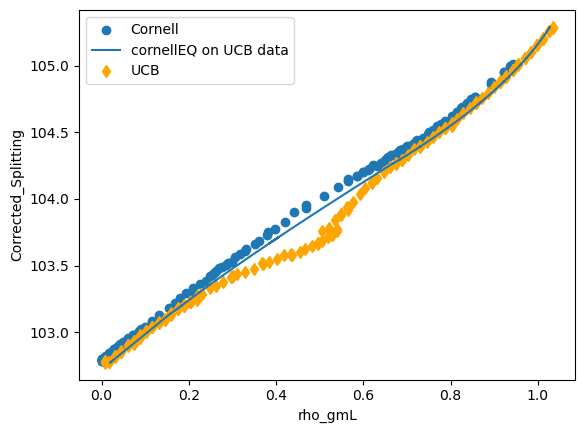

In [82]:
fig,ax=plt.subplots()

x='rho_gmL'
y='Corrected_Splitting'
ax.errorbar(x=merged_df[x],y=merged_df[y], fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2,
           label='UCB')


ax.scatter(cornellcell['Density from EOS  (g/ml)'][cornellcell['T (ID)']==37],
           cornellcell['Ne corrected ∆CO2  (cm-1)'][cornellcell['T (ID)']==37], label='Cornell')

ax.plot(merged_df['cornellEQ_predrho'],merged_df[y],label='cornellEQ on UCB data')
# ax2=ax.twinx()
# ax2.plot(merged_df['Corrected_Splitting'],merged_df['median_temp'],color='darkred')
# ax2.set_ylabel('Sensor_T')

ax.set_xlabel(x)
ax.set_ylabel(y)
plt.legend()


plt.show()